## Evaluate the ML models and produce verification diagrams 

In [1]:
# The custom classifier 
import sys
sys.path.append('/home/monte.flora/python_packages/wofs_ml_severe')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')

from ml_workflow import TunedEstimator 
from wofs_ml_severe import load_ml_data
from wofs_ml_severe.common.emailer import Emailer 
from verification_diagrams.verification_diagrams import plot_verification

import numpy as np
from os.path import join
import joblib

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def load_ml_model(name, target, resample, lead_time, retro_str='retro', return_X_y=False):
    """Load ML or baseline model."""
    BASE_PATH = '/work/mflora/ML_DATA/NEW_ML_MODELS'
    
    fname = f'{name}_{target}_{resample}_{lead_time}_{retro_str}.joblib'
    
    path = join(BASE_PATH, fname)
    
    data = joblib.load(path)
    
    model = data['model']
    
    if return_X_y:
        X = data['X']
        y = data['y']
        return model, X, y
    else:
        return model

In [3]:
names = ['RandomForest', 'LogisticRegression', 'XGBoost', 'Baseline']
resample='None'
lead_time = 'first_hour'
target = 'wind_severe_0km'

BL_DICT = {'hail_severe_0km': 'hail_nmep_>1.0_0km__prob_max',
           'wind_severe_0km': 'wind_nmep_>40_0km__prob_max',
          }

models = [load_ml_model(name, target, resample, lead_time) for name in names]

# Load the data. 
mode = 'testing'
X, y, metadata = load_ml_data(target_col=target, 
                                  lead_time=lead_time,
                                  mode=mode,
                                 )

X_bl, y, metadata = load_ml_data(target_col=target, 
                                  lead_time=lead_time,
                                  mode=mode,
                                  baseline=True
                                 )

X_bl = X_bl[BL_DICT[target]]

[10:29:38] WARNING: ../src/gbm/gbtree.cc:405: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[10:29:38] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


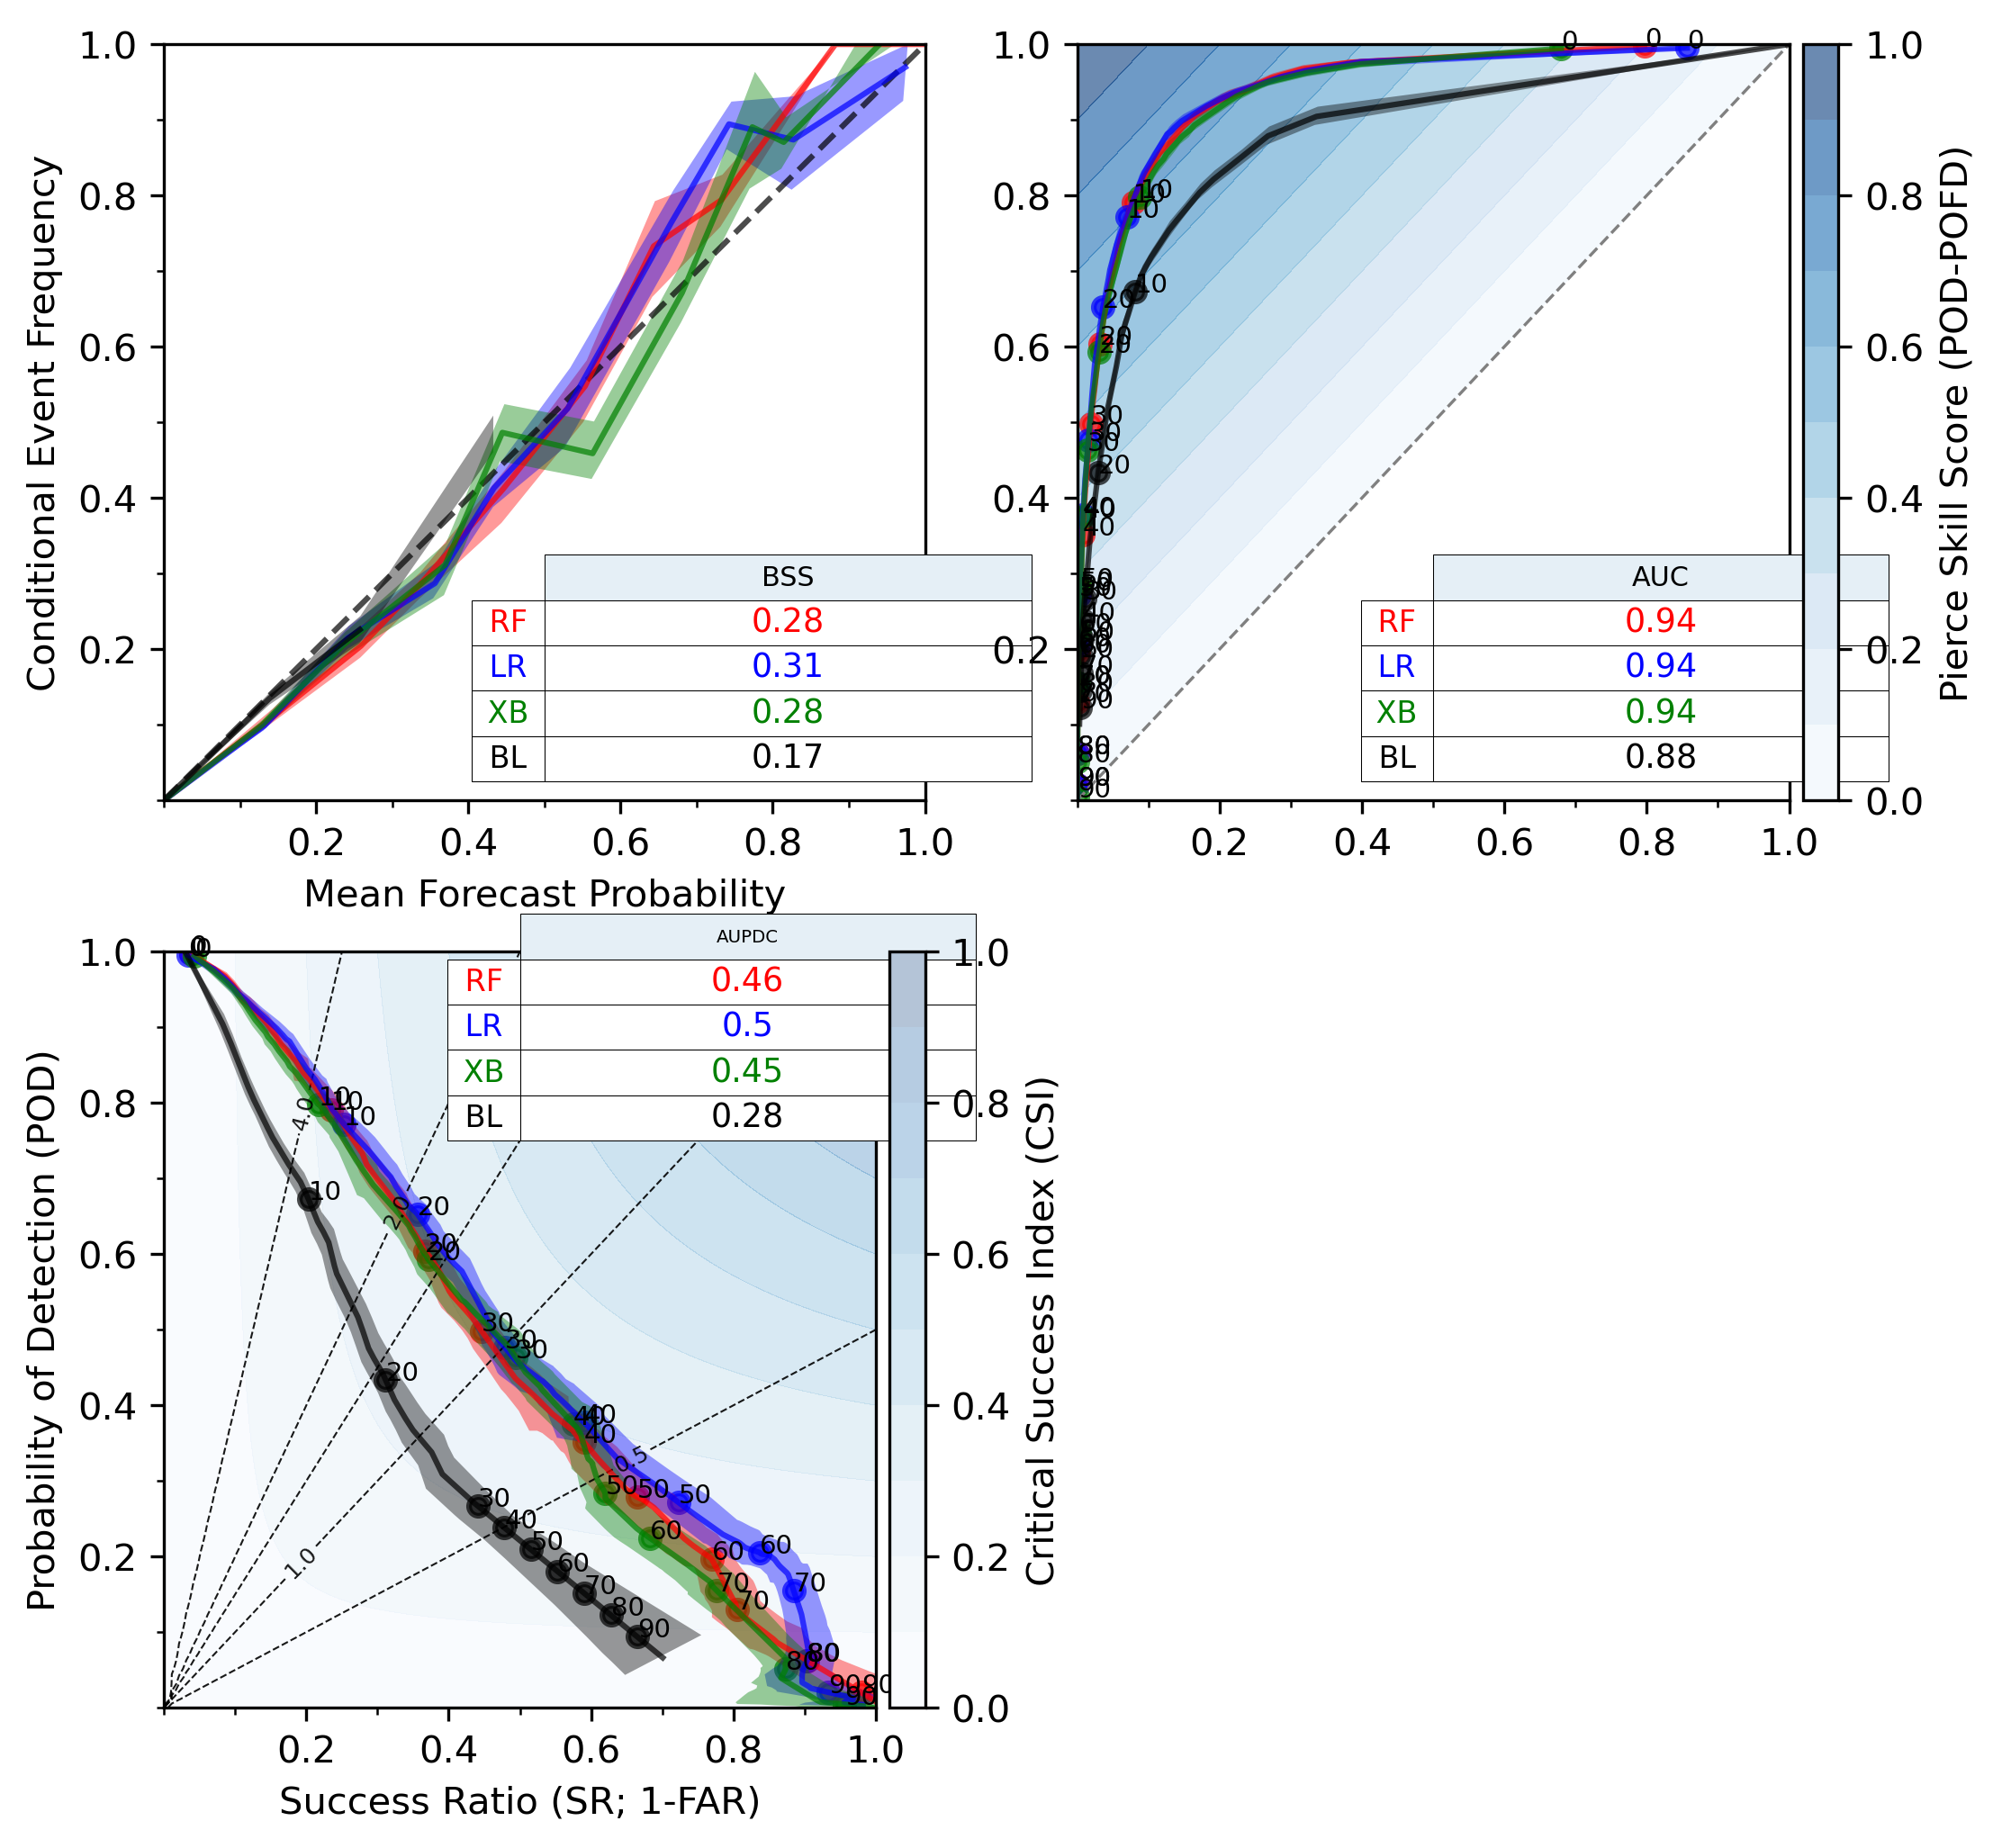

In [4]:
%matplotlib inline

y_test = y.values
y_pred = [model.predict_proba(X)[:,1] for model in models[:-1]]
bl_pred = [models[-1].predict(X_bl.values.reshape(-1,1))]

y_pred += bl_pred

names = ['RF', 'LR', 'XB', 'BL']
plot_verification(y_test, y_pred, names, n_boot=30)

In [5]:
from sklearn.metrics import average_precision_score

average_precision_score(y, models[-1].predict(X_bl.values.reshape(-1,1)))

0.28014422423232105